In [12]:
"""
Trains on Romo with some shaping
"""

import sys
sys.path.append('../')

from low_rank_rnns import romo
from low_rank_rnns.modules import *
from low_rank_rnns.helpers import *
from matplotlib import pyplot as plt


In [13]:

hidden_size = 512
noise_std = 5e-3
alpha = 0.2
lr_base = 1e-2


In [11]:

x_train, y_train, mask_train, x_val, y_val, mask_val = romo.generate_data(1000)
net_fr = FullRankRNN(1, hidden_size, 1, noise_std, alpha)
train(net_fr, x_train, y_train, mask_train, n_epochs=5, lr=lr_base / sqrt(hidden_size), batch_size=32, keep_best=True, cuda=True)
x_val, y_val, mask_val = map_device([x_val, y_val, mask_val], net_fr)
out = net_fr.forward(x_val)
print("Final loss: {:.3f}".format(loss_mse(out, y_val, mask_val)))





Training...
initial loss: 0.261
epoch 0:  loss=0.124  (took 6.07 s) *
epoch 1:  loss=0.079  (took 6.06 s) *
epoch 2:  loss=0.064  (took 5.92 s) *
epoch 3:  loss=0.042  (took 5.99 s) *
epoch 4:  loss=0.023  (took 5.99 s) *
Final loss: 0.025


In [35]:
# test 

x_train, y_train, mask_train, x_val, y_val, mask_val = romo.generate_data(1000)
loss, acc = romo.test_romo(net_fr, x_val, y_val, mask_val)

In [36]:
out = net_fr.forward(x_val)


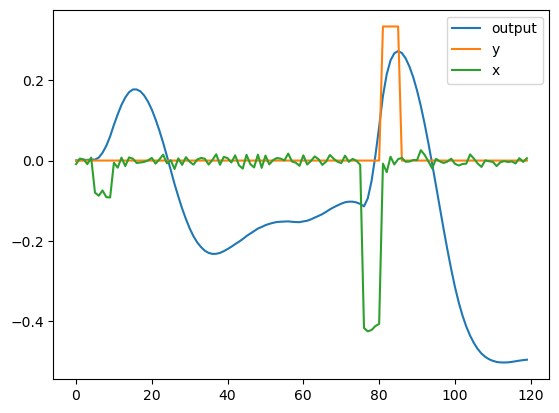

In [56]:

n = 30

aa = out.detach().numpy()
plt.plot(aa[n,:,:], label = 'output')
plt.plot(y_val[n,:,:], label = 'y')
plt.plot(x_val[n,:,:], label = 'x')
plt.legend()

In [48]:
bb = y_val.detach().numpy()
np.mean(bb)

-0.0014583333

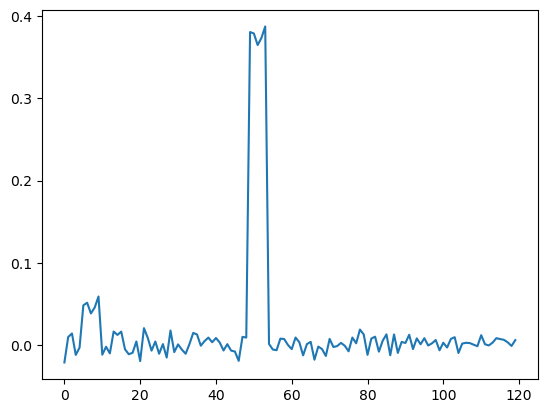

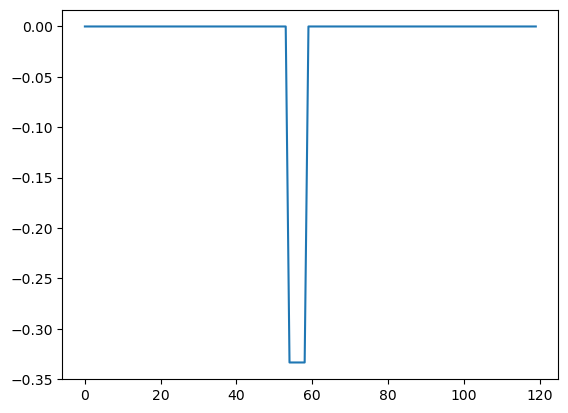

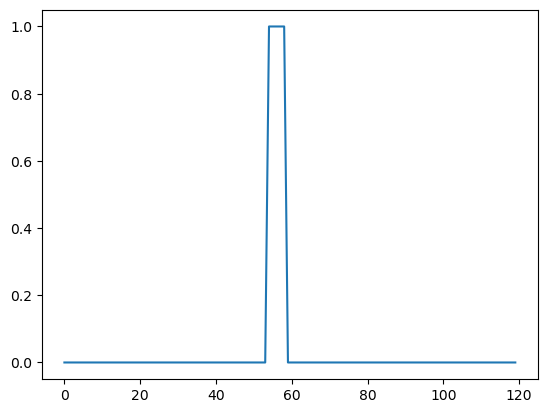

In [28]:

plt.figure()
plt.plot(x_train[n,:,:])
plt.figure()
plt.plot(y_train[n,:,:])
plt.figure()
plt.plot(mask_train[n,:,:])

# lower-rank RNN

In [ ]:
# romo.delay_duration_max = 1000
# romo.setup()
x_train, y_train, mask_train, x_val, y_val, mask_val = romo.generate_data(1000)
wi_init = net_fr.wi_full.detach()
wo_init = net_fr.wo_full.detach() * hidden_size
print(wo_init.std())
wrec = net_fr.wrec.detach().cpu().numpy()
u, s, v = np.linalg.svd(wrec)
m_init = torch.from_numpy(s[:2] * u[:, :2]).to(device=net_fr.wrec.device) * sqrt(hidden_size)
n_init = torch.from_numpy(v[:2, :].transpose()).to(device=net_fr.wrec.device) * sqrt(hidden_size)
print(m_init.std())
print(n_init.std())



net = LowRankRNN(1, hidden_size, 1, noise_std, alpha, rank=2, wi_init=wi_init, wo_init=wo_init, m_init=m_init, n_init=n_init)
# net = LowRankRNN(1, hidden_size, 1, noise_std, alpha, rank=2)
train(net, x_train, y_train, mask_train, n_epochs=100, lr=lr_base, batch_size=32, keep_best=True, cuda=True, clip_gradient=1, early_stop=0.001)
x_val, y_val, mask_val = map_device([x_val, y_val, mask_val], net)
out = net.forward(x_val)
print("Final loss: {:.3f}".format(loss_mse(out, y_val, mask_val)))



# romo.delay_duration_max = 2000
# romo.setup()
# x_train, y_train, mask_train, x_val, y_val, mask_val = romo.generate_data(1000)
# train(net, x_train, y_train, mask_train, n_epochs=100, lr=lr_base, keep_best=True, cuda=True, clip_gradient=.1, early_stop=0.004)
# x_val, y_val, mask_val = map_device([x_val, y_val, mask_val], net)
# out = net.forward(x_val)
# print("Final loss: {:.3f}".format(loss_mse(out, y_val, mask_val)))




In [ ]:
# save the model
torch.save(net.state_dict(), "../models/romo_rank2_{}.pt".format(hidden_size))
